In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 40kB 1.9MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.13.4-cp36-none-any.whl size=29944 sha256=6c21ec90ddc726ca3d53d9670242c9584b8510bb808ab3505e6dd2e8f1e0a698
  Stored in directory: /root/.cache/pip/wheels/d1/14/6d/b36f1618f939480ce5baa48e4d918ea00669f1cbbec4419514
  Created wheel for py-params: filename=py_params-0.8.2-cp36-none-any.whl size=4635 sha256=212f468f1f096daa1f6ac1dd2a4fdcc286cdee8d55c8e087411a65fb4b4459df
  Stored in directory: /root/.cache/pip/wheels/83/3a/9c/baf35d6f17f0c2c6b61bf8ac3ab9fc12df0e41432ccaeecacb
  Created wheel for params-flow: filename=params_flow-0.7.4-cp36-none-any.whl size=16195 sha256=2d2bd6adf9a1a4e29007b58584bc849005a9831225853db5066a300a44046b8b
  Stored in directory: /root/.cache/pip/wheels/86/30/40/507b60d68b67ac87f35e95c98f5b296a32f146d5ae1d1d5aa7
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.0MB 4.8MB/s 


In [0]:
!pip install kss

  Created wheel for kss: filename=kss-1.2.5-cp36-cp36m-linux_x86_64.whl size=247634 sha256=16177992e36cc69ede757fe0b60db866b3fdafa32ba91b1abca6fdb16a43157b
  Stored in directory: /root/.cache/pip/wheels/ac/9c/07/cbce306cb767e7428e4da5301e55834937ed1984ba564ca993
Successfully built kss


In [0]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from keras.preprocessing.sequence import pad_sequences
import bert

Using TensorFlow backend.


In [0]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import pickle
import random
import math
import kss

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/LAB/국민청원/petition_data_all_2019_01_09.csv'
data = pd.read_csv(data_path)

In [0]:
data.head()

,num,category,start-days,end-days,person,progress,title,count,petition_overview
0,21,안전/환경,2017-08-19,2017-11-17,kakao - ***,청원종료,스텔라 데이지호에 대한 제안입니다.,9,\n\t\t\t\t\t\t\t\t\t\t\t스텔라 데이지호에 대한 제안입니다. \n...
1,22,기타,2017-08-19,2017-11-17,kakao - ***,청원종료,비리제보처를 만들어주세요.,17,\n\t\t\t\t\t\t\t\t\t\t\t현 정부에 국민들이 가장 원하는 것은 부...
2,23,미래,2017-08-19,2017-09-03,kakao - ***,청원종료,제2의 개성공단,0,\n\t\t\t\t\t\t\t\t\t\t\t만일 하시는 대통령님 및 각 부처 장관님...
3,24,일자리,2017-08-19,2017-08-26,kakao - ***,청원종료,공공기관 무조건적인 정규직전환을 반대합니다.,53,\n\t\t\t\t\t\t\t\t\t\t\t현정부에서 정규직 일자리를 늘리는 것에 ...
4,25,미래,2017-08-19,2017-09-03,kakao - ***,청원종료,제2의 개성공단,0,\n\t\t\t\t\t\t\t\t\t\t\t만일 하시는 대통령님 및 각 부처 장관님...


In [0]:
print(data.isnull().values.any())

False


In [0]:
len(data)

371230

In [0]:
data = data.drop_duplicates(subset='petition_overview', keep='last')

In [0]:
len(data)

352988

In [0]:
print(data.groupby('category').size().sort_values(ascending=False))

category
정치개혁           53258
기타             43175
인권/성평등         31114
안전/환경          27542
교통/건축/국토       25899
외교/통일/국방       24462
육아/교육          23557
보건복지           22330
일자리            20631
행정             18145
문화/예술/체육/언론    16571
미래             16114
경제민주화          15203
성장동력            6469
반려동물            3629
저출산/고령화대책       3199
농산어촌            1690
dtype: int64


In [0]:
category_selected = ['정치개혁', '인권/성평등', '안전/환경', '교통/건축/국토', '외교/통일/국방']

In [0]:
df = data[data['category'].isin(category_selected)]
df.head()

,num,category,start-days,end-days,person,progress,title,count,petition_overview
0,21,안전/환경,2017-08-19,2017-11-17,kakao - ***,청원종료,스텔라 데이지호에 대한 제안입니다.,9,\n\t\t\t\t\t\t\t\t\t\t\t스텔라 데이지호에 대한 제안입니다. \n...
6,27,정치개혁,2017-08-19,2017-09-18,naver - ***,청원종료,김이수 헌재소장 임명 재고 건의,1,\n\t\t\t\t\t\t\t\t\t\t\t문 대통령님께 묻습니다 (2017. 8....
12,33,인권/성평등,2017-08-19,2017-11-17,naver - ***,청원종료,납득할 수 있는 장애 재판정을 받고 싶습니다.,15,\n\t\t\t\t\t\t\t\t\t\t\t안녕하십니까? 저는 경직형 양마비 뇌병변...
14,35,외교/통일/국방,2017-08-19,2017-08-26,kakao - ***,청원종료,문재인정부는 신한국형 페리프로세스가 작성했습니다.,0,\n\t\t\t\t\t\t\t\t\t\t\t문재인 대통령님 신한국형 페리프로세스 로...
15,36,인권/성평등,2017-08-19,2017-08-26,naver - ***,청원종료,한국채식인구 100만명. 학교 급식 및 군대에서 현미채식 선택권을 보장해주십시오!,1,\n\t\t\t\t\t\t\t\t\t\t\t문재인 대통령님과 각 정부 인사분들께 마...


In [0]:
X = df['petition_overview']

In [0]:
y = df['category']

In [0]:
X[:10]

0     \n\t\t\t\t\t\t\t\t\t\t\t스텔라 데이지호에 대한 제안입니다. \n...
6     \n\t\t\t\t\t\t\t\t\t\t\t문 대통령님께 묻습니다 (2017. 8....
12    \n\t\t\t\t\t\t\t\t\t\t\t안녕하십니까? 저는 경직형 양마비 뇌병변...
14    \n\t\t\t\t\t\t\t\t\t\t\t문재인 대통령님 신한국형 페리프로세스 로...
15    \n\t\t\t\t\t\t\t\t\t\t\t문재인 대통령님과 각 정부 인사분들께 마...
17    \n\t\t\t\t\t\t\t\t\t\t\t문재인 대통령님 한중관계 사드 갈등 해소...
19    \n\t\t\t\t\t\t\t\t\t\t\t지금부터 67년전 1950년 6.25전쟁...
25    \n\t\t\t\t\t\t\t\t\t\t\t지금부터 67년전 1950년 6.25전쟁...
30    \n\t\t\t\t\t\t\t\t\t\t\t간절히 간절히 간청 드립니다. \n\n\...
54    \n\t\t\t\t\t\t\t\t\t\t\t※지장물관련 국토부의 해석 : 기존 건축...
Name: petition_overview, dtype: object

In [0]:
X = X.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [0]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer =  hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1", 
                             trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [0]:
tokenizer.tokenize("봄에 이어 이번 가을 겨울에도 어김없이 미세먼지가 왔습니다")

['봄',
 '##에',
 '이어',
 '이',
 '##번',
 '가',
 '##을',
 '겨',
 '##울',
 '##에도',
 '어',
 '##김',
 '##없',
 '##이',
 '미',
 '##세',
 '##먼',
 '##지가',
 '왔',
 '##습',
 '##니다']

In [0]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("봄에 이어 이번 가을 겨울에도 어김없이 미세먼지가 왔습니다"))

[9360,
 10530,
 64749,
 9638,
 35465,
 8843,
 10622,
 8877,
 78123,
 35979,
 9546,
 118667,
 119136,
 10739,
 9309,
 24982,
 118922,
 80795,
 9594,
 119081,
 48345]

In [0]:
def encode_sentence(sent):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent))

In [0]:
label_dict = {'정치개혁': 0, '인권/성평등': 1, '안전/환경': 2, '교통/건축/국토': 3, '외교/통일/국방': 4}

In [0]:
X_bert = [encode_sentence(text) for text in X]

In [0]:
y_bert = []
for label in y:
    y_bert.append(label_dict[label])

In [0]:
print(len(X_bert))
print(len(y_bert))

162275
162275


In [0]:
data_with_len = [[sent, y_bert[i], len(sent)]
                 for i, sent in enumerate(X_bert)]
random.shuffle(data_with_len)
data_with_len.sort(key=lambda x: x[2])
sorted_all = [(sent_lab[0], sent_lab[1])
              for sent_lab in data_with_len if sent_lab[2] > 5]

In [0]:
sorted_all = np.array(sorted_all)
X = sorted_all[:, 0].tolist()
y = sorted_all[:, 1].tolist()

In [0]:
X = pad_sequences(X, maxlen=256, dtype="long", truncating="post", padding="post")

In [0]:
print(len(X))
print(len(y))

161049
161049


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [0]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x) # batch_size, nb_filters, seq_len-1)
        x_1 = self.pool(x_1) # (batch_size, nb_filters)
        x_2 = self.trigram(x) # batch_size, nb_filters, seq_len-2)
        x_2 = self.pool(x_2) # (batch_size, nb_filters)
        x_3 = self.fourgram(x) # batch_size, nb_filters, seq_len-3)
        x_3 = self.pool(x_3) # (batch_size, nb_filters)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

In [0]:
VOCAB_SIZE = len(tokenizer.vocab)
EMB_DIM = 256
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 5

DROPOUT_RATE = 0.2

NB_EPOCHS = 5

In [0]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [0]:
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [0]:
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/LAB/국민청원/"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

Latest checkpoint restored!!


In [0]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        ckpt_manager.save()
        print("Checkpoint saved at {}.".format(checkpoint_path))

In [0]:
Dcnn.summary()

Model: "dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  30604032  
_________________________________________________________________
conv1d (Conv1D)              multiple                  51300     
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  76900     
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  102500    
_________________________________________________________________
global_max_pooling1d (Global multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  77056     
_________________________________________________________________
dropout (Dropout)            multiple                  0      

In [0]:
Dcnn.fit(X_train, y_train,
         epochs=NB_EPOCHS,
         callbacks=[MyCustomCallback()])

Train on 128839 samples
Epoch 1/5
128839/128839 [==============================] - 1177s 9ms/sample - loss: 0.4153 - sparse_categorical_accuracy: 0.8604
Epoch 2/5
128839/128839 [==============================] - 1158s 9ms/sample - loss: 0.2882 - sparse_categorical_accuracy: 0.8978
Epoch 3/5
128839/128839 [==============================] - 1149s 9ms/sample - loss: 0.2243 - sparse_categorical_accuracy: 0.9186
Epoch 4/5
128839/128839 [==============================] - 1143s 9ms/sample - loss: 0.1873 - sparse_categorical_accuracy: 0.9325
Epoch 5/5
128839/128839 [==============================] - 1145s 9ms/sample - loss: 0.1681 - sparse_categorical_accuracy: 0.9396


In [0]:
Dcnn.evaluate(X_test, y_test)

32210/32210 [==============================] - 5s 148us/sample - loss: 0.6720 - sparse_categorical_accuracy: 0.8143


[0.6720039014896226, 0.81425023]

In [0]:
y_pred = Dcnn.predict(X_test)

In [0]:
y_pred = Dcnn.predict(X_test).argmax(axis=-1)

In [0]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=category_selected, columns=category_selected)

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum > /dev/null

In [0]:
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

In [0]:
# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 52824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44428 missing from current font.
  font.set_

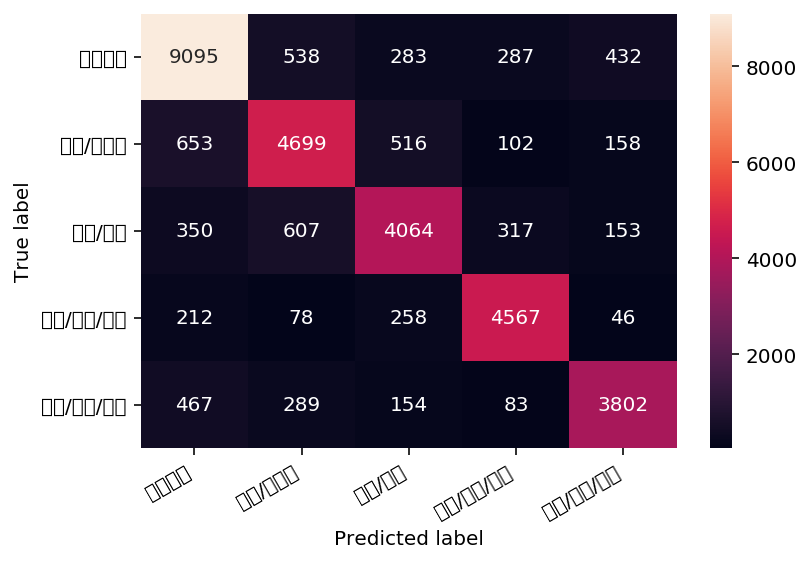

In [0]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
mpl.pyplot.ylabel('True label')
mpl.pyplot.xlabel('Predicted label');